# Bayesian Monte Carlo techniques
$$\chi^2 = \displaystyle \sum_{i = 1}^N \frac{\left(y_i - a - b x_i\right)^2}{\sigma_i^2}$$

We will stick to linear models, correlated uncertainties in $x$ and $y$, and flat priors on the parameters.

## Reminder on frequentist vs. Bayesian
Let's say we have an experiment that gives us $x,y,\sigma_y$ and we want the best fit line to the data points. If we were to repeat the experiment many times and each value of $x$ we measure a distribution of outcomes then the frequentist approach is the correct approach since an error bar expresses a distribution for a data point. However this is not feasible if we make only one measurement. In this case, the error bars are really telling you how confident your model is (thus implying that the plots we usually make are wrong, but that's often overlooked).

In bayesian statistics we want:

$$P(a,b|data) = CP(data|a,b)P(a,b) $$

where what we calculate is $P(data|a,b)$ and the prior $P(a,b)$.

If we assume that all measurements are uncorrelated then we can write $P(data|a,b)$ as the product of the exponential of the square difference divided by the uncertainty. If the uncertainties are uncorrelated then maximizing the probability amounts to minimizing chi2, which appears in the exponent.

Downside of Bayesian statistics is that you are unable to ask if your model is appropriate, but you can compare models against each other.

## Bivariate Gaussian Distribution
Let's pretend our data is bivariate Gaussian distributions. Then the likelihood that we are going to measure a particular value of $x_i,y_i$ is
$$P(x_i,y_i|x,y,S_i) = \frac{1}{2\pi|S_i|}\exp\left(-\frac{1}{2}[Z_i-Z]^TS_i^{-1}[Z_i-Z\right)$$
where $Z_i^T = \left[x_i\ y_i\right]$ and $S_i$ is the uncertainty matrix with uncertainties $\sigma_{x_i}^2$ on the diagonal and cross products $\sigma_{xy_i}$ on the off diagonals. If the cross products are 0 then the inverse is simple to calculate. Let's assume the cross terms are 0.

After doing all matrix multiplications we are left with
$$P(x_i,y_i|x,y,S_i) = \frac{1}{2\pi\sigma_{x_i}\sigma_{y_i}} \exp\left(-\frac{1}{2}\left( \frac{(x_i-x)^2}{\sigma_{x_i}^2} + \frac{(y_i-y)^2}{\sigma_{y_i}^2}  \right)\right)$$

This is just the prodcut of two gaussians.

## General case
Oftentimes we also call $\sigma_{xy_i}/\sigma_{x_i}\sigma_{y_i} = \rho$ and we call this the correlation and redefine $S$ with that, where $\rho\leq1$. $S$ is now called the correlation matrix (was the covariance matrix before). Now, we can rewrite $P$ as

$$P(...) = \frac{1}{2\pi\sigma_{x_i}\sigma_{y_i}\sqrt{1-\rho^2}} \exp\left(-\frac{1}{2\sqrt{1-\rho^2}}\left( \frac{(x_i-x)^2}{\sigma_{x_i}^2} + \frac{(y_i-y)^2}{\sigma_{y_i}^2} -2\rho\frac{(x_i-x)(y_i-y)}{\sigma_{x_i}\sigma_{y_i}}\right)\right)$$

In the lmit of $\rho$ being 1 then we have a circle, otherwise the ratio of the x and y uncertainties tell you the orientation of your elipses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import corner
from scipy import integrate
from scipy import optimize as op
import utilities as utes
%matplotlib inline

In [2]:
#First define the uncertainties and x and y values
sigxi, sigyi = 1.0,1.0
x,y = 2,3

In [3]:
def get_xi_yi(sigxi,sigyi,x,y,rho):
    Ndata = 1000
    z1,z2 = utes.get_fake_gaussian_data(Ndata)
    xi = sigxi*z1+x
    yi = sigyi*(rho*z1+np.sqrt(1-rho**2)*z2)+y
    return xi,yi

def get_yi_line(xi,sigx,sigy,x,y,rho):
    return np.sign(rho)*sigy/sigx*(xi-x) + y

def make_plots(sigx,sigy,x,y,rho):
    xi_s,yi_s = get_xi_yi(sigx,sigy,x,y,rho)
    xi = np.linspace(x-4,x+4,1000)
    yi = get_yi_line(xi,sigx,sigy,x,y,rho)
    return xi_s,yi_s,xi,yi

xi_n05,yi_n05 = get_xi_yi(sigxi,sigyi,x,y,-0.5)
xi_0,yi_0 = get_xi_yi(sigxi,sigyi,x,y,0)
xi_p05,yi_p05 = get_xi_yi(sigxi,sigyi,x,y,0.5)

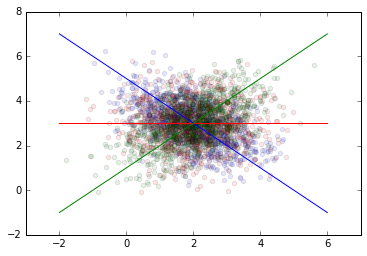

In [4]:
for rho,c in zip([-0.5,0.0,0.5],['b','r','g']):
    xi_s,yi_s,xi,yi = make_plots(sigxi,sigyi,x,y,rho)
    plt.scatter(xi_s,yi_s,alpha=0.1,c=c)
    plt.plot(xi,yi,c=c)

## Finding x and y
In the example above, we wrote down the means of xi and yi as x and y. But if we don't know them a priori then we have to find them by marginalizing over the distance of our xi and yi from our model. This is done by the closest perpendicular approach.

Steps of this approach:

1) find a vector $\vec{m}^T = [1\ b]$ that is parallel to our model line some angle $\delta$ above the x-axis.
2) Write the unit vector $\vec{u}^T = \frac{1}{|\vec{u}|}[u_x\ 1]$ so that u dotted into m is 0, and so that $u_x = -b$ and it points from the 
3) The vector $\vec{d}^T = [x_i\ y_i-a]$ where $a$ is intercept of our model.
4) Then $\Delta_i = \vec{d}\cdot\vec{u} = \vec{u}^T\vec{Z}_i-a/\sqrt{1+b^2}$.
5) Then we can write this $\Delta_i$ as a gaussian
$$\sim\exp \left[-\frac{\Delta_i^2}{\Sigma_i^2}\right]$$
where
$$\Sigma_i^2 = \vec{u}^TS_i\vec{u}.$$

Now we can write:
$$P(data|model) = \prod_{i=1}P(x_i,y_i|a,b,S_i)$$
Where now $P(...)$ is given by the equation above for $\Delta_i$. Note that:
$$\Delta_i^2 = \frac{(y_i-a-bx_i)^2}{1+b^2}$$
and
$$\Sigma_i^2 = \frac{b^2\sigma_{x_i}^2 + \sigma_{y_i}^2}{1+b^2}$$
for $\rho = 0$.

We will now calculate
$$\log P \propto -\frac{1}{2}\sum \frac{(y_i-a-bx_i)^2}{\sigma_{y_i}^2+b^2\sigma_{x_i}^2}.$$
We will then find the normalizaton quantity by finding this peak log likelihood and setting it equal to 0.

In [5]:
def logp(params,x,y,sigx,sigy):
    a,b = params
    ymodel = a+b*x
    return -1./2.*np.sum((y-ymodel)**2/(sigx**2+b**2*sigy**2))

def nlogp(params,x,y,sigx,sigy):
    return -logp(params,x,y,sigx,sigy)

atrue,btrue = 1.0,2.0
Ndata = 100
sigx,sigy = .05,.05
x = np.linspace(1,4,Ndata) + np.random.randn(Ndata)*sigx #Make the x points
y = atrue + btrue*x + np.random.randn(Ndata)*sigy

In [6]:
res = op.minimize(nlogp,x0=[atrue-0.5,btrue+0.5],args =(x,y,sigx,sigy),method="Powell")
print res
print nlogp(res['x'],x,y,sigx,sigy)

   direc: array([[ 0.        ,  1.        ],
       [ 1.14439054, -0.4233052 ]])
     fun: 12.587845474631376
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 4
  status: 0
 success: True
       x: array([ 1.01807586,  1.99260904])
12.5878454746


In [7]:
#Now we find the normalization of our probability so that max(P) = 1
k = res['fun']
C = np.exp(k)

def Prob1(a,b,C,x,y,sigx,sigy):
    return C*np.exp(logp([a,b],x,y,sigx,sigy))

#Do the double integral to find the normalization
norm = integrate.nquad(Prob1,[[0,3],[0,3]],args=(C,x,y,sigx,sigy))[0]

#Now the following function will give P normalized such that the integral
#under it is equal to 1
def Prob(a,b,norm,C,x,y,sigx,sigy):
    return Prob1(a,b,C,x,y,sigx,sigy)/norm

## Countours
Now we need to go back to some february notes and figure out how to get contours. First step I think is to make a 2D array of P values in a,b space.

In [8]:
#First make our 2D array
N_arr = 100
abest, bbest = res['x']
aspread, bspread = 0.1, 0.2 #This is arbitrary
a_arr = np.linspace(abest-aspread,abest+aspread,N_arr)
b_arr = np.linspace(bbest-bspread,bbest+bspread,N_arr)
A,B = np.meshgrid(a_arr,b_arr)
P_arr = np.zeros((100,N_arr))
for i in range(len(a_arr)):
    for j in range(len(b_arr)):
        a,b = a_arr[i],b_arr[j]
        P_arr[i,j] = Prob(a,b,norm,C,x,y,sigx,sigy)

Now we can use the utilities package and the conf_intervals_2D function to find the values of P that contain the 0.6827, 0.9545 and 0.9973 values (1 sigma 2 sigma and 3 sigma values).

In [10]:
import utilities as utes
P68 = utes.conf_2D_bound(A,B,P_arr,C0=0.68)
P95 = utes.conf_2D_bound(A,B,P_arr,C0=0.95)
P99 = utes.conf_2D_bound(A,B,P_arr,C0=0.99)

print P68, P95, P99

361.963213442 56.8236520003 9.85021278868


The utilities function conf_2D_bound figures out the level in P that we need to provide to matplotlib's contour function to get correct contours. How to do so is demonstrated in the next cell. Note that the levels come out squiggle, since P is actually a giant square matrix.

<a list of 4 text.Text objects>

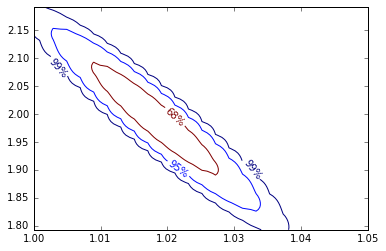

In [19]:
levels = [P99,P95,P68]
CP = plt.contour(A,B,P_arr,levels=levels)
plt.xlim(1.00,1.05)

strs = ["99%","95%","68%"]
for l, s in zip(CP.levels, strs):
    fmt[l] = s

plt.clabel(CP, fmt=fmt, fontsize=10)